# DDPG PROJECT

Import gym and define pendulum environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import numpy as np
from matplotlib import pyplot as plt

#env = gym.make('Pendulum-v1', g=9.81, render_mode = 'human')

Check API-conformity

In [3]:
from gym.utils.env_checker import check_env

Import helpers

In [4]:
from helpers import *

## 3) Heuristic policy

##### Wrap environment in a NormalizedEnv class

In [5]:
env = gym.make('Pendulum-v1', g=9.81)
#env = gym.make('Pendulum-v1', g=9.81, render_mode = 'human')
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<PendulumEnv<Pendulum-v1>>>>>

In [6]:
env = NormalizedEnv(env)
env

<NormalizedEnv<TimeLimit<OrderEnforcing<PassiveEnvChecker<PendulumEnv<Pendulum-v1>>>>>>

##### RandomAgent

In [7]:
random_agent = RandomAgent(env)

In [8]:
rewards = np.zeros((10,200))

for i in range(10):
    state = env.reset()
    state = state[0]
    
    trunc = False
    cur_reward = []
    
    while not trunc:   
        action = random_agent.compute_action(state) 
        (next_state, reward, term, trunc, info) = env.step(action)
        state = next_state
        cur_reward.append(reward)
        
        if term or trunc:
            observation, info = env.reset()
    
    rewards[i] = cur_reward

rand_rewards = rewards

##### Heuristic pendulum agent

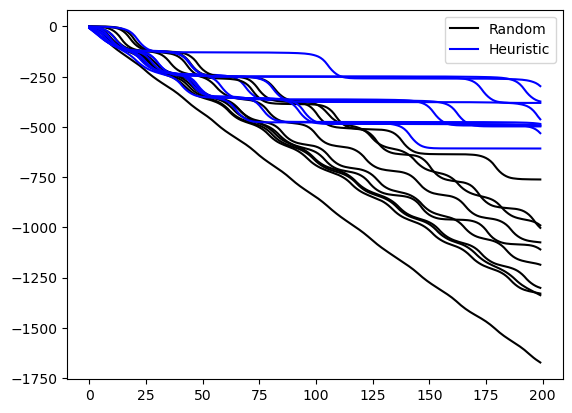

In [9]:
heur_agent = HeuristicPendulumAgent(env, 0.8)
rewards = np.zeros((10,200))

for i in range(10):
    state = env.reset()
    state = state[0]

    trunc = False
    cur_reward = []

    while not trunc:
        action = heur_agent.compute_action(state) 
        (next_state, reward, term, trunc, info) = env.step(action)
        state = next_state
        cur_reward.append(reward)

        if term or trunc:
            observation, info = env.reset()
            
    rewards[i] = cur_reward

heur_rewards = rewards

plt.figure()
plt.plot(np.arange(200), np.cumsum(rand_rewards[0]),'k',label='Random')
plt.plot(np.arange(200), np.cumsum(heur_rewards[0]),'b', label='Heuristic')
plt.legend()
[plt.plot(np.arange(200), np.cumsum(rand_rewards[i]),'k') for i in range(1,len(rand_rewards))]
[plt.plot(np.arange(200), np.cumsum(heur_rewards[i]),'b') for i in range(1,len(heur_rewards))]
plt.show()

Effect of fixed torque

Text(0, 0.5, 'Avg. total reward (over 10 runs)')

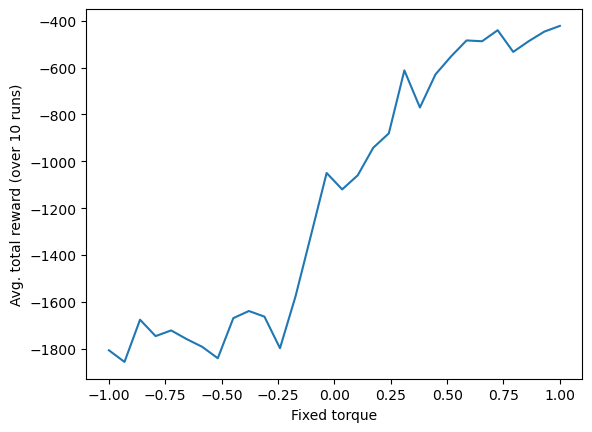

In [10]:
torques = np.linspace(-1,1,30)
avg_rewards = []

for t in torques:
    heur_agent = HeuristicPendulumAgent(env,t)
    rewards = []

    for _ in range(10):
        state = env.reset()
        state = state[0]

        trunc = False
        cur_reward = 0

        while not trunc:
            action = heur_agent.compute_action(state) 
            (next_state, reward, term, trunc, info) = env.step(action)
            state = next_state
            cur_reward += reward

            if term or trunc:
                observation, info = env.reset()

        rewards.append(cur_reward)
    avg_rewards.append(np.mean(rewards))

plt.figure()
plt.plot(torques, avg_rewards)
plt.xlabel('Fixed torque')
plt.ylabel('Avg. total reward (over 10 runs)')

In [11]:
# env.close()

## 4) Q function of the heuristic policy

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

In [13]:
def train_epoch(model, agent, optimizer, criterion, gamma, Buffer, epoch, device):
    model.eval()
    state = env.reset()
    state = state[0]
    Trunc = False
    loss_epoch = []
    while not Trunc:
        with torch.no_grad():
            action = agent.compute_action(state) 
        (next_state, reward, term, Trunc, info) = env.step(action)
        Buffer.store_transition((state, action, reward, next_state, Trunc))
        state = next_state
        #print(Buffer.buffer[-1])
        if (len(Buffer.buffer) >= 128):
            model.train()
            b = Buffer.batch_buffer(128)
            data = np.zeros((128,4))
            reward = np.zeros(128)
            next_data = np.zeros((128,4))
            trunc = np.zeros(128)
            for i,transition in enumerate(b):  
                data[i] = np.concatenate((transition[0], transition[1]))
                reward[i] = transition[2]
                trunc[i] = transition[4]
                with torch.no_grad():           
                    next_data[i] = np.concatenate((transition[3], agent.compute_action(transition[3])))

            data = torch.tensor(data, dtype=torch.float32).to(device)   
            reward = torch.tensor(reward, dtype=torch.float32).to(device)
            next_data = torch.tensor(next_data, dtype=torch.float32).to(device)
            trunc = torch.tensor(trunc, dtype = torch.bool)

            optimizer.zero_grad()
            output = model(data)  # (state, action) -> Q(s, a)
            #print(output)
            with torch.no_grad():
                target = (reward + gamma*model(next_data).flatten()).reshape(128,1)
            #print(target)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss_epoch.append(loss.item())
            
    
    return np.mean(loss_epoch)

In [14]:
heur_agent = HeuristicPendulumAgent(env,0.8)
max_size = 1e4

device = "cpu"
model = QNetwork().to(device)
lr = 1e-4
gamma = 0.99
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = torch.nn.MSELoss()
num_epochs = 1000
Buffer = ReplayBuffer(max_size = max_size)

net_dir = 'Models/Q_network'
if not os.path.exists(net_dir):
    os.makedirs(net_dir)

try:
    model.load_state_dict(torch.load(net_dir+'/model.pt', map_location=torch.device('cpu')))
    print('Loading network')
except:
    history = []

    for epoch in range(num_epochs):
        loss = train_epoch(model, heur_agent, optimizer, criterion, gamma, Buffer, epoch, device)
        if epoch%25 == 0:
            print(f'Epoch: {epoch}, loss: {loss:.3f}')
        history.append(loss)
    
    torch.save(model.state_dict(), net_dir+'/model.pt')
    np.save(net_dir+'/history.npy', history)

    model.load_state_dict(torch.load(net_dir+'/model.pt', map_location=torch.device('cpu')))


Epoch: 0, loss: 21.056
Epoch: 25, loss: 312.865
Epoch: 50, loss: 114.020
Epoch: 75, loss: 77.492
Epoch: 100, loss: 38.139
Epoch: 125, loss: 26.551
Epoch: 150, loss: 19.004
Epoch: 175, loss: 18.545
Epoch: 200, loss: 20.546
Epoch: 225, loss: 22.892
Epoch: 250, loss: 22.991
Epoch: 275, loss: 24.077
Epoch: 300, loss: 24.765
Epoch: 325, loss: 25.386
Epoch: 350, loss: 24.677
Epoch: 375, loss: 22.413
Epoch: 400, loss: 21.046
Epoch: 425, loss: 21.211
Epoch: 450, loss: 20.582
Epoch: 475, loss: 21.287
Epoch: 500, loss: 20.080
Epoch: 525, loss: 21.770
Epoch: 550, loss: 20.210
Epoch: 575, loss: 19.881
Epoch: 600, loss: 21.356
Epoch: 625, loss: 19.569
Epoch: 650, loss: 19.148
Epoch: 675, loss: 19.691
Epoch: 700, loss: 19.256
Epoch: 725, loss: 20.500
Epoch: 750, loss: 19.504
Epoch: 775, loss: 21.221
Epoch: 800, loss: 20.086
Epoch: 825, loss: 19.379
Epoch: 850, loss: 18.820
Epoch: 875, loss: 20.284
Epoch: 900, loss: 20.389
Epoch: 925, loss: 20.018
Epoch: 950, loss: 19.588
Epoch: 975, loss: 20.083
[21

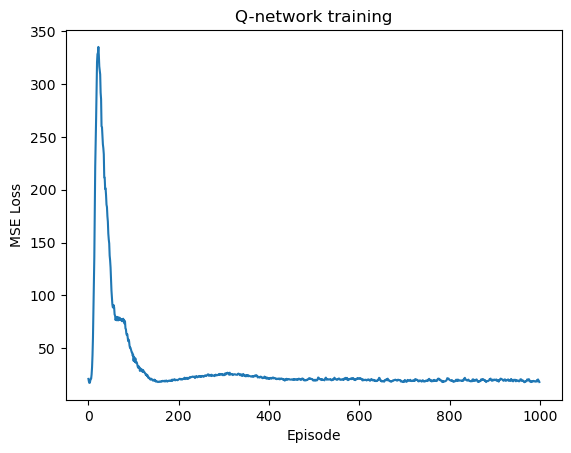

In [15]:
history = np.load(net_dir+'/history.npy')
plt.plot(np.arange(len(history)), history)
plt.xlabel('Episode')
plt.ylabel('MSE Loss')
plt.title('Q-network training')
plt.savefig(f'Plots/Q_training_{len(history)}.png')

In [16]:
def compute_reward(alpha, alpha_speed, torque):
    return -(alpha**2 + 0.1*alpha_speed**2 + 0.001*torque**2)

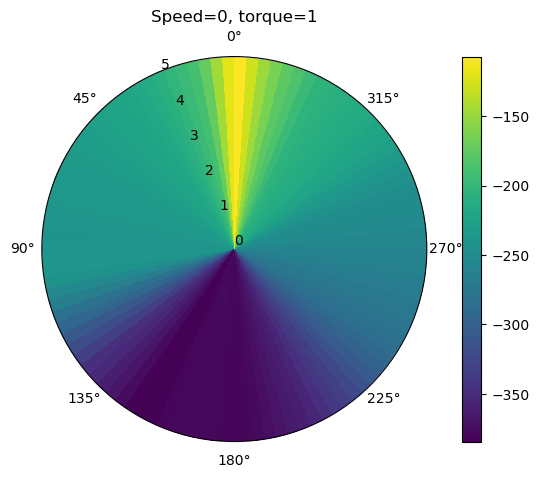

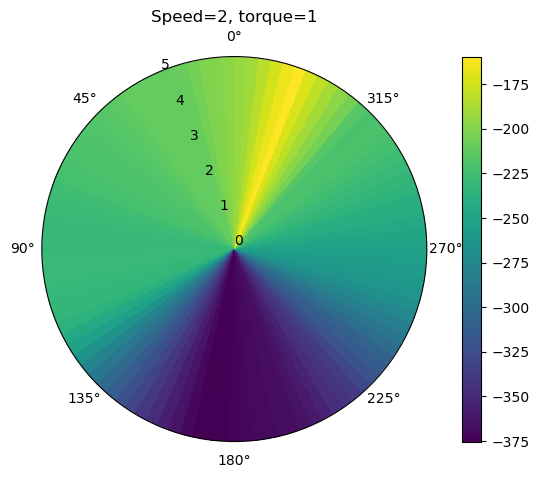

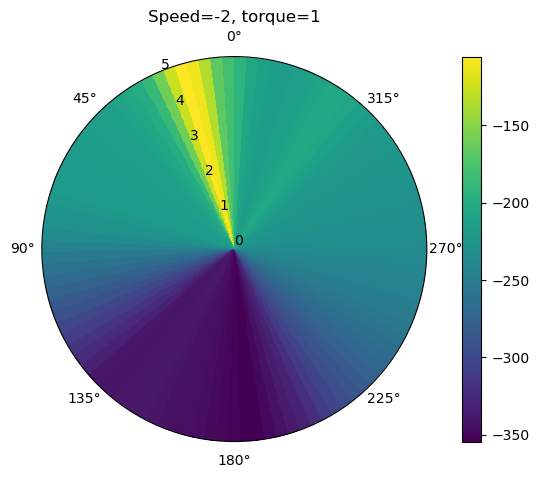

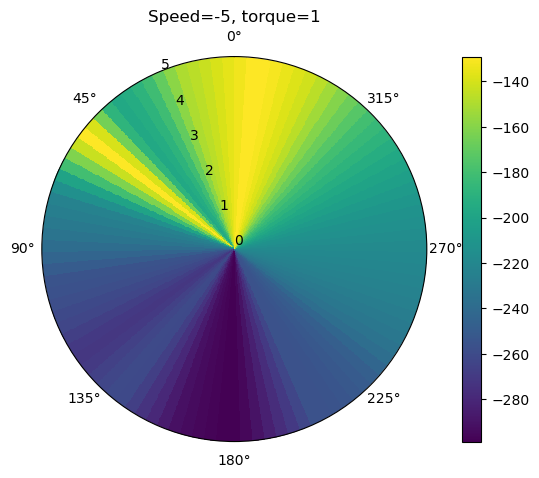

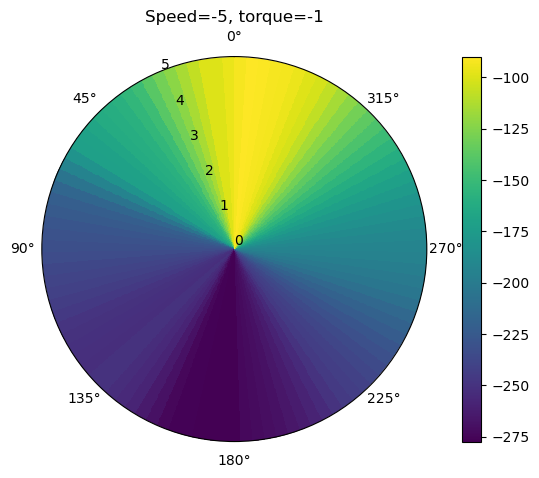

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

logs = [(0,1),(2,1),(-2,1),(-5,1),(-5,-1)]

for l in logs:
    speed = l[0]
    torque = l[1]
    
    fig = plt.figure(figsize=(20, 5))
    
    rad = np.linspace(0, 5, 100)
    azm = np.linspace(-np.pi, np.pi, 100)
    r, th = np.meshgrid(rad, azm)
    
    # Q-Network
    speed_array = speed*np.ones(r.shape)
    torque_array = torque*np.ones(r.shape)
    data = np.stack([np.cos(th), np.sin(th), speed_array, torque_array], axis = 2)
    data = torch.tensor(data, dtype = torch.float32)
    z = model(data)
    z = z.detach().numpy().squeeze()

    ax1 = fig.add_subplot(121, projection="polar")
    ax1.grid(False)
    pc = ax1.pcolormesh(th, r, z)
    ax1.plot(azm, r, color='k', ls='none') 
    ax1.set_theta_zero_location('N')
    fig.colorbar(pc)
    plt.title(f'Speed={speed}, torque={torque}')
    plt.savefig(f'Plots/Q_heat_{speed}_{torque}.png')

## 5) Minimal Implementation of DDPG

In [18]:
def compute_loss_policy(state, action, model_Q):
    #with torch.no_grad():
    #model_Q.eval()
    #action.detach().numpy()  
    data = torch.cat((state, action), axis = 1)
    #data = torch.tensor(data, dtype=torch.float32).to(device)   
    loss_policy = torch.mean(-model_Q(data))
    #loss_policy.requires_grad = True
    return loss_policy


def train_epoch_policy(model_policy, model_Q, agent, optimizer, criterion, gamma, Buffer, epoch, device):
    state = env.reset()
    state = state[0]

    Trunc = False
    loss_epoch = []
    while not Trunc:
        model_policy.eval()
        with torch.no_grad():
            action = agent.compute_action(state)
        (next_state, reward, term, Trunc, info) = env.step(action)
        Buffer.store_transition((state, action, reward, next_state, Trunc))
        state = next_state
    
        if len(Buffer.buffer) >= 128:
            model_Q.eval()
            model_policy.train()
            b = Buffer.batch_buffer(128)
            data = np.zeros((128,3))
            reward = np.zeros(128)
            next_data = np.zeros((128,3))
            trunc = np.zeros(128)
            for i,transition in enumerate(b):        
                data[i] = transition[0]
                reward[i] = transition[2]
                trunc[i] = transition[4]
                next_data[i] = transition[3]

            data = torch.tensor(data, dtype=torch.float32).to(device)   
            reward = torch.tensor(reward, dtype=torch.float32).to(device)
            next_data = torch.tensor(next_data, dtype=torch.float32).to(device)
            trunc = torch.tensor(trunc, dtype = torch.bool)
            optimizer.zero_grad()
            output = model_policy(data)  # state -> action
            
            loss = compute_loss_policy(data, output, model_Q)
            # loss = criterion(loss_p, torch.zeros([128,1], requires_grad = True))
            loss.backward()
            optimizer.step()
            loss_epoch.append(loss.item())

    return np.mean(loss_epoch)

In [19]:
device = "cpu"

# Define DDPG agent
noise_std = 0.3
ddpg_agent = DDPGAgent(noise_std, device)

 
# model_Q = QNetwork().to(device)
# model_policy = PolicyNetwork().to(device)

max_size = 1e5
Buffer = ReplayBuffer(max_size = max_size)


# Training parameters, ecc...
lr = 1e-4
gamma = 0.99
optimizer_Q = torch.optim.Adam(ddpg_agent.Q_network.parameters(), lr = lr)
optimizer_policy = torch.optim.Adam(ddpg_agent.policy_network.parameters(), lr = lr)
criterion_Q = torch.nn.MSELoss()
criterion_policy = torch.nn.L1Loss()
num_epochs = 1000

state = env.reset()
state = state[0]

net_dir = 'Models/DDPG_network'
if not os.path.exists(net_dir):
    os.makedirs(net_dir)

try:
    model.load_state_dict(torch.load(net_dir+'/model.pt', map_location=torch.device('cpu')))
    print('Loading network')
except: 
    history_Q = []
    history_policy = []

    for epoch in range(num_epochs):

        loss_Q = train_epoch(ddpg_agent.Q_network, ddpg_agent, optimizer_Q, criterion_Q, gamma, Buffer, epoch, device)
        loss_policy = train_epoch_policy(ddpg_agent.policy_network, ddpg_agent.Q_network, ddpg_agent, optimizer_policy, criterion_policy, gamma, Buffer, epoch, device)
        if epoch%25 == 0:
            print(f'Epoch: {epoch}, loss Q: {loss_Q:.3f}, loss pol: {loss_policy:.3f}')       
        history_Q.append(loss_Q)
        history_policy.append(loss_policy)
    
    torch.save(model.state_dict(), net_dir+'/model.pt')
    np.save(net_dir+'/history_Q.npy', history_Q)
    np.save(net_dir+'/history_policy.npy', history_policy)
    model.load_state_dict(torch.load(net_dir+'/model.pt', map_location=torch.device('cpu')))

Epoch: 0, loss Q: 57.790, loss pol: 0.252
Epoch: 25, loss Q: 304.403, loss pol: 427.300
Epoch: 50, loss Q: 1231.571, loss pol: 511.613
Epoch: 75, loss Q: 239.732, loss pol: 524.618
Epoch: 100, loss Q: 40.304, loss pol: 580.061
Epoch: 125, loss Q: 24.846, loss pol: 579.463
Epoch: 150, loss Q: 13.798, loss pol: 592.017
Epoch: 175, loss Q: 20.081, loss pol: 553.995
Epoch: 200, loss Q: 29.660, loss pol: 497.022
Epoch: 225, loss Q: 30.349, loss pol: 418.157
Epoch: 250, loss Q: 47.059, loss pol: 376.737
Epoch: 275, loss Q: 59.073, loss pol: 351.552
Epoch: 300, loss Q: 79.025, loss pol: 330.874
Epoch: 325, loss Q: 68.623, loss pol: 260.594
Epoch: 350, loss Q: 30.313, loss pol: 136.902
Epoch: 375, loss Q: 26.047, loss pol: 141.643
Epoch: 400, loss Q: 31.971, loss pol: 158.262
Epoch: 425, loss Q: 27.632, loss pol: 107.285
Epoch: 450, loss Q: 26.398, loss pol: 66.929
Epoch: 475, loss Q: 28.105, loss pol: 54.148
Epoch: 500, loss Q: 31.832, loss pol: 31.467
Epoch: 525, loss Q: 32.350, loss pol: 8.

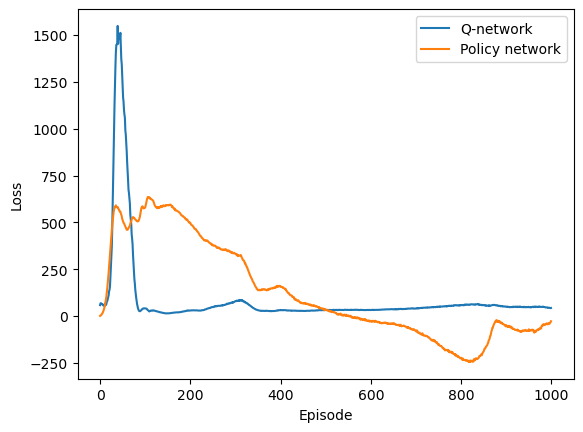

In [20]:
history_Q = np.load(net_dir+'/history_Q.npy')
history_policy = np.load(net_dir+'/history_policy.npy')
plt.figure()
plt.plot(history_Q)
plt.plot(history_policy)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend(['Q-network','Policy network'])
plt.savefig(f'Plots/DDPG_training_{len(history_Q)}.png')

Simulation

In [21]:
# env = gym.make('Pendulum-v1', g=9.81, render_mode = 'human')

# rewards = np.zeros((5,200))

# for i in range(5):
#     state = env.reset()
#     state = state[0]
    
#     trunc = False
#     cur_reward = []
    
#     while not trunc:   
#         action = ddpg_agent.compute_action(model_policy, state, deterministic = True) 
#         (next_state, reward, term, trunc, info) = env.step(action)
#         state = next_state
#         cur_reward.append(reward)
        
#         if term or trunc:
#             observation, info = env.reset()
    
#     rewards[i] = cur_reward

# rand_rewards = rewards

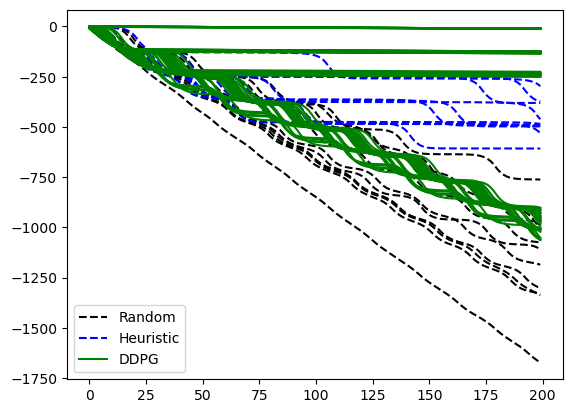

In [22]:
# env = gym.make('Pendulum-v1', g=9.81)
rewards = np.zeros((100,200))

#Buffer = ReplayBuffer(max_size = 400)

for i in range(100):
    state = env.reset()
    state = state[0]

    trunc = False
    cur_reward = []

    while not trunc:
        action = ddpg_agent.compute_action(state, deterministic = True) 
        (next_state, reward, term, trunc, info) = env.step(action)
        state = next_state
        cur_reward.append(reward)

        if term or trunc:
            observation, info = env.reset()
            
    rewards[i] = cur_reward

ddpg_rewards = rewards

plt.figure()
plt.plot(np.arange(200), np.cumsum(rand_rewards[0]),'--k',label='Random')
plt.plot(np.arange(200), np.cumsum(heur_rewards[0]),'--b', label='Heuristic')
plt.plot(np.arange(200), np.cumsum(ddpg_rewards[0]),'g', label='DDPG')
plt.legend()
[plt.plot(np.arange(200), np.cumsum(rand_rewards[i]),'--k') for i in range(1,len(rand_rewards))]
[plt.plot(np.arange(200), np.cumsum(heur_rewards[i]),'--b') for i in range(1,len(heur_rewards))]
[plt.plot(np.arange(200), np.cumsum(ddpg_rewards[i]),'g') for i in range(1,len(ddpg_rewards))]
plt.show()

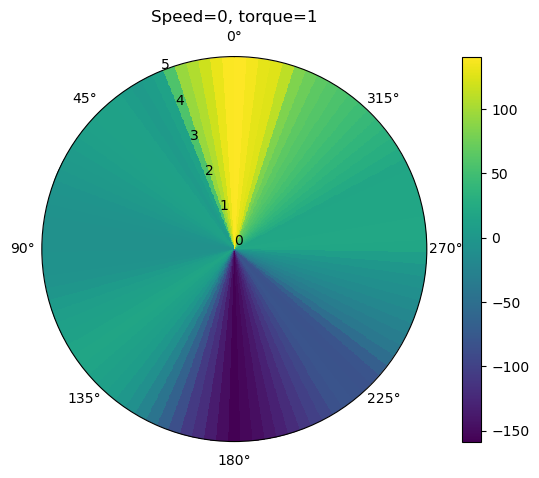

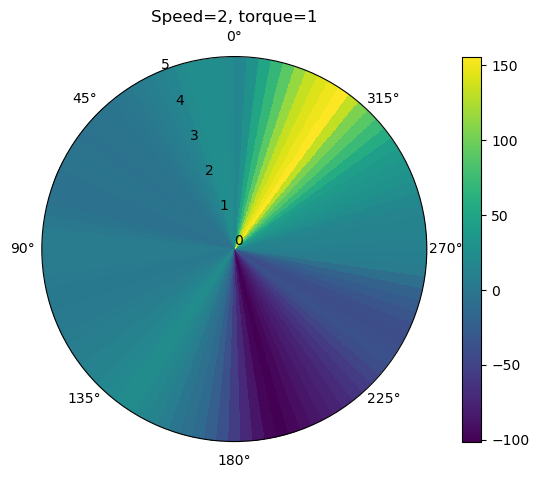

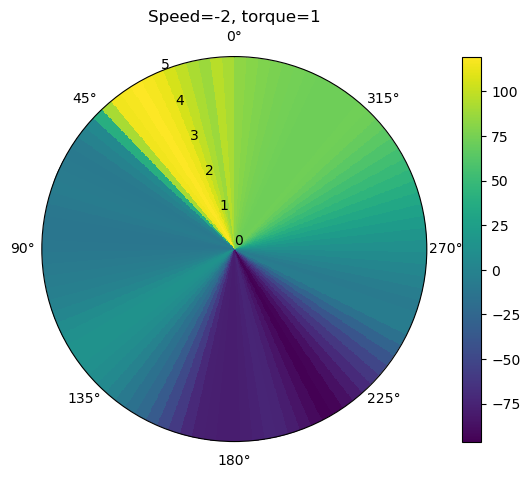

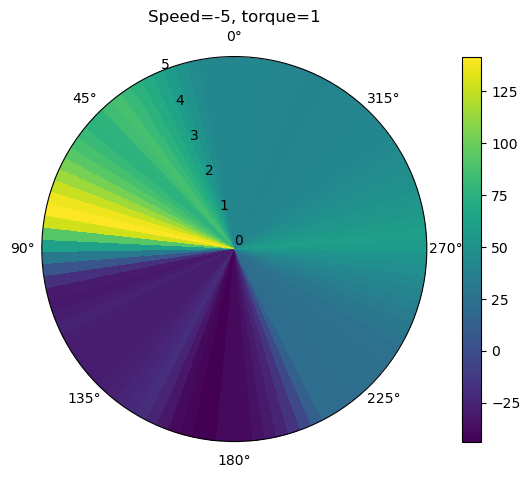

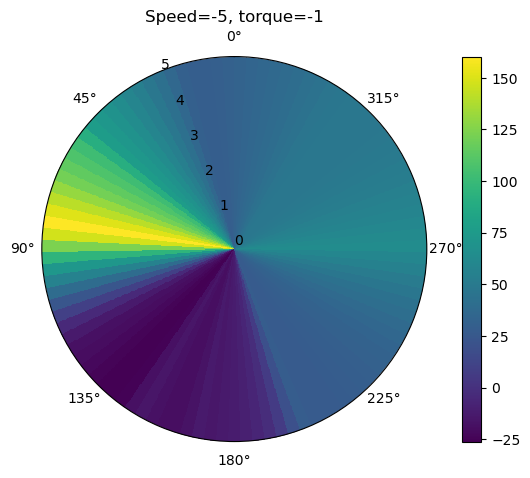

In [23]:
logs = [(0,1),(2,1),(-2,1),(-5,1),(-5,-1)]

for l in logs:
    speed = l[0]
    torque = l[1]
    
    fig = plt.figure(figsize=(20, 5))
    
    rad = np.linspace(0, 5, 100)
    azm = np.linspace(-np.pi, np.pi, 100)
    r, th = np.meshgrid(rad, azm)
    
    # Q-Network
    speed_array = speed*np.ones(r.shape)
    torque_array = torque*np.ones(r.shape)
    data = np.stack([np.cos(th), np.sin(th), speed_array, torque_array], axis = 2)
    data = torch.tensor(data, dtype = torch.float32)
    z = ddpg_agent.Q_network(data)
    z = z.detach().numpy().squeeze()
    
    ax1 = fig.add_subplot(121, projection="polar")
    ax1.grid(False)
    pc = ax1.pcolormesh(th, r, z)
    ax1.plot(azm, r, color='k', ls='none') 
    ax1.set_theta_zero_location('N')
    fig.colorbar(pc)
    plt.title(f'Speed={speed}, torque={torque}')
    plt.savefig(f'Plots/DDPG_heat_{speed}_{torque}.png')

# 6) Target Networks

In [24]:
def train_epoch_target(model, target_model, agent, optimizer, criterion, gamma, Buffer, epoch, device):
    model.eval()
    state = env.reset()
    state = state[0]
    Trunc = False
    loss_epoch = []
    while not Trunc:
        with torch.no_grad():
            action = agent.compute_action(state) 
        (next_state, reward, term, Trunc, info) = env.step(action)
        Buffer.store_transition((state, action, reward, next_state, Trunc))
        state = next_state
        #print(Buffer.buffer[-1])
        if (len(Buffer.buffer) >= 128):
            model.train()
            b = Buffer.batch_buffer(128)
            data = np.zeros((128,4))
            reward = np.zeros(128)
            next_data = np.zeros((128,4))
            trunc = np.zeros(128)
            for i,transition in enumerate(b):  
                data[i] = np.concatenate((transition[0], transition[1]))
                reward[i] = transition[2]
                trunc[i] = transition[4]
                with torch.no_grad():           
                    next_data[i] = np.concatenate((transition[3], agent.compute_action(transition[3], deterministic = True, use_target = True)))  ###### USE TARGET NETWORK

            data = torch.tensor(data, dtype=torch.float32).to(device)   
            reward = torch.tensor(reward, dtype=torch.float32).to(device)
            next_data = torch.tensor(next_data, dtype=torch.float32).to(device)
            trunc = torch.tensor(trunc, dtype = torch.bool)

            optimizer.zero_grad()

            output = model(data)  # (state, action) -> Q(s, a)
            #print(output)
            with torch.no_grad():
                target = (reward + gamma*target_model(next_data).flatten()).reshape(128,1) ###### USE TARGET NETWORK
            #print(target)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss_epoch.append(loss.item())
            
    
    return np.mean(loss_epoch)


def train_epoch_policy_target(model_policy, model_Q, target_model_policy, target_model_Q, agent, optimizer, criterion, gamma, Buffer, epoch, device):
    
    state = env.reset()
    state = state[0]

    Trunc = False
    loss_epoch = []
    while not Trunc:
        model_policy.eval()
        with torch.no_grad():
            action = agent.compute_action(state)
        (next_state, reward, term, Trunc, info) = env.step(action)
        Buffer.store_transition((state, action, reward, next_state, Trunc))
        state = next_state
    
        if len(Buffer.buffer) >= 128:
            model_Q.eval()
            model_policy.train()
            b = Buffer.batch_buffer(128)
            data = np.zeros((128,3))
            reward = np.zeros(128)
            next_data = np.zeros((128,3))
            trunc = np.zeros(128)
            for i,transition in enumerate(b):        
                data[i] = transition[0]
                reward[i] = transition[2]
                trunc[i] = transition[4]
                next_data[i] = transition[3]

            data = torch.tensor(data, dtype=torch.float32).to(device)   
            reward = torch.tensor(reward, dtype=torch.float32).to(device)
            next_data = torch.tensor(next_data, dtype=torch.float32).to(device)
            trunc = torch.tensor(trunc, dtype = torch.bool)
            optimizer.zero_grad()
            output = model_policy(data)  # state -> action
            
            loss = compute_loss_policy(data, output, model_Q)  #### USE TARGET Q NETWORK

            loss.backward()
            optimizer.step()
            loss_epoch.append(loss.item())

    return np.mean(loss_epoch)

Epoch: 0, loss Q: 40.616, loss pol: 0.440
Epoch: 25, loss Q: 0.325, loss pol: 7.107
Epoch: 50, loss Q: 0.048, loss pol: 7.310
Epoch: 75, loss Q: 0.015, loss pol: 7.500
Epoch: 100, loss Q: 0.009, loss pol: 7.512
Epoch: 125, loss Q: 0.006, loss pol: 7.504
Epoch: 150, loss Q: 0.005, loss pol: 7.487
Epoch: 175, loss Q: 0.004, loss pol: 7.517
Epoch: 200, loss Q: 0.003, loss pol: 7.494
Epoch: 225, loss Q: 0.003, loss pol: 7.461
Epoch: 250, loss Q: 0.002, loss pol: 7.410
Epoch: 275, loss Q: 0.002, loss pol: 7.462
Epoch: 300, loss Q: 0.002, loss pol: 7.490
Epoch: 325, loss Q: 0.002, loss pol: 7.448
Epoch: 350, loss Q: 0.001, loss pol: 7.438
Epoch: 375, loss Q: 0.001, loss pol: 7.452
Epoch: 400, loss Q: 0.001, loss pol: 7.456
Epoch: 425, loss Q: 0.001, loss pol: 7.439
Epoch: 450, loss Q: 0.001, loss pol: 7.459
Epoch: 475, loss Q: 0.001, loss pol: 7.423
Epoch: 500, loss Q: 0.001, loss pol: 7.496
Epoch: 525, loss Q: 0.001, loss pol: 7.446
Epoch: 550, loss Q: 0.001, loss pol: 7.446
Epoch: 575, los

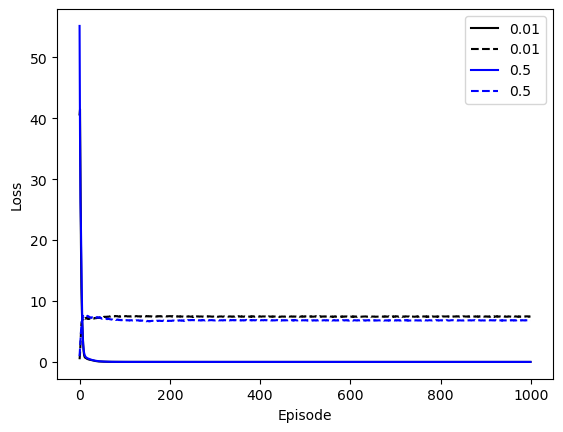

In [25]:
device = "cpu"

# Define DDPG agent
noise_std = 0.3
TAU = [0.01, 0.5] ##### !!!!!!!!!!!!!!!! Salvare agente per ogni tau, per plot dopo?

plt.figure()
colors = ['k','b']
#           ,'r','g','y']

for col, tau in zip(colors,TAU):
    
    ddpg_agent = DDPGAgent(sigma = noise_std, device = device, tau = tau)

    # 
    # model_Q = QNetwork().to(device)
    # model_policy = PolicyNetwork().to(device)
    
    # Initialize buffer (here????)
    max_size = 1e5
    Buffer = ReplayBuffer(max_size = max_size)
    
    # Training parameters, ecc...
    lr = 1e-4
    gamma = 0.99
    optimizer_Q = torch.optim.Adam(ddpg_agent.Q_network.parameters(), lr = lr)
    optimizer_policy = torch.optim.Adam(ddpg_agent.policy_network.parameters(), lr = lr)
    criterion_Q = torch.nn.MSELoss()
    criterion_policy = torch.nn.L1Loss()
    num_epochs = 1000
    net_dir = 'Models/target_network/tau_'+str(tau)
    
    if not os.path.exists(net_dir):
        os.makedirs(net_dir)

    try:
        model.load_state_dict(torch.load(net_dir+'/model.pt', map_location=torch.device('cpu')))
        print('Loading network')
    except:    
        history_Q = []
        history_policy = []

        state = env.reset()
        state = state[0]

        for epoch in range(num_epochs):
            loss_Q = train_epoch_target(ddpg_agent.Q_network, ddpg_agent.target_Q_network, ddpg_agent, optimizer_Q, criterion_Q, gamma, Buffer, epoch, device)
            loss_policy = train_epoch_policy_target(ddpg_agent.policy_network, ddpg_agent.Q_network, ddpg_agent.target_policy_network, ddpg_agent.target_Q_network, ddpg_agent, optimizer_policy, criterion_policy, gamma, Buffer, epoch, device)

            ddpg_agent.update_target_params

            if epoch%25 == 0:
                print(f'Epoch: {epoch}, loss Q: {loss_Q:.3f}, loss pol: {loss_policy:.3f}')
            history_Q.append(loss_Q)
            history_policy.append(loss_policy)

        torch.save(model.state_dict(), net_dir+'/model.pt')
        np.save(net_dir+'/history_Q.npy', history_Q)
        np.save(net_dir+'/history_policy.npy', history_policy)
        model.load_state_dict(torch.load(net_dir+'/model.pt', map_location=torch.device('cpu')))

    history_Q = np.load(net_dir+'/history_Q.npy')
    history_policy = np.load(net_dir+'/history_policy.npy')
    plt.plot(history_Q,col+'-',label=f'{tau}')
    plt.plot(history_policy,col+'--',label=f'{tau}')

plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'Plots/DDPG_training_target_{len(history_Q)}.png')

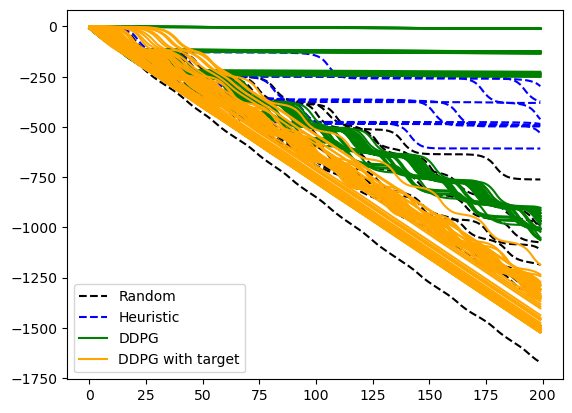

In [26]:
# env = gym.make('Pendulum-v1', g=9.81)
rewards = np.zeros((100,200))

#Buffer = ReplayBuffer(max_size = 400)

for i in range(100):
    state = env.reset()
    state = state[0]

    trunc = False
    cur_reward = []

    while not trunc:
        action = ddpg_agent.compute_action(state, deterministic = True) 
        (next_state, reward, term, trunc, info) = env.step(action)
        state = next_state
        cur_reward.append(reward)

        if term or trunc:
            observation, info = env.reset()
            
    rewards[i] = cur_reward

ddpg_target_rewards = rewards

plt.figure()
plt.plot(np.arange(200), np.cumsum(rand_rewards[0]),'--k',label='Random')
plt.plot(np.arange(200), np.cumsum(heur_rewards[0]),'--b', label='Heuristic')
plt.plot(np.arange(200), np.cumsum(ddpg_rewards[0]),'g', label='DDPG')
plt.plot(np.arange(200), np.cumsum(ddpg_target_rewards[0]),'orange', label='DDPG with target')
plt.legend()
[plt.plot(np.arange(200), np.cumsum(rand_rewards[i]),'--k') for i in range(1,len(rand_rewards))]
[plt.plot(np.arange(200), np.cumsum(heur_rewards[i]),'--b') for i in range(1,len(heur_rewards))]
[plt.plot(np.arange(200), np.cumsum(ddpg_rewards[i]),'g') for i in range(1,len(ddpg_rewards))]
[plt.plot(np.arange(200), np.cumsum(ddpg_target_rewards[i]),'orange') for i in range(1,len(ddpg_target_rewards))]
plt.show()

# 7) Ornstein-Uhlenbeck Noise

In [27]:
device = "cpu"

# Define DDPG agent
noise_std = 0.3
tau = 0.5 ### Change
THETA = [0.01,0.5]

plt.figure()
colors = ['k','b']
#           ,'r','g','y']

for col, theta in zip(colors,THETA):
    ddpg_agent = DDPGAgent(sigma = noise_std, device = device, tau = tau, theta = theta, OUNoise = True)
    
    # Initialize buffer (here????)
    max_size = 1e5
    Buffer = ReplayBuffer(max_size = max_size)
    
    # Training parameters, ecc...
    lr = 1e-4
    gamma = 0.99
    optimizer_Q = torch.optim.Adam(ddpg_agent.Q_network.parameters(), lr = lr)
    optimizer_policy = torch.optim.Adam(ddpg_agent.policy_network.parameters(), lr = lr)
    criterion_Q = torch.nn.MSELoss()
    criterion_policy = torch.nn.L1Loss()
    num_epochs = 1000
    net_dir = 'Models/OU_network/theta_'+str(theta)
    
    if not os.path.exists(net_dir):
        os.makedirs(net_dir)

    try:
        model.load_state_dict(torch.load(net_dir+'/model.pt', map_location=torch.device('cpu')))
        print('Loading network')
    except:    
        history_Q = []
        history_policy = []

        state = env.reset()
        state = state[0]

        for epoch in range(num_epochs):
            ddpg_agent.noise = OUActionNoise(theta, noise_std)

            loss_Q = train_epoch_target(ddpg_agent.Q_network, ddpg_agent.target_Q_network, ddpg_agent, optimizer_Q, criterion_Q, gamma, Buffer, epoch, device)
            loss_policy = train_epoch_policy_target(ddpg_agent.policy_network, ddpg_agent.Q_network, ddpg_agent.target_policy_network, ddpg_agent.target_Q_network, ddpg_agent, optimizer_policy, criterion_policy, gamma, Buffer, epoch, device)

            ddpg_agent.update_target_params

            if epoch%25 == 0:
                print(f'Epoch: {epoch}, loss Q: {loss_Q:.3f}, loss pol: {loss_policy:.3f}')
            history_Q.append(loss_Q)
            history_policy.append(loss_policy)

        torch.save(model.state_dict(), net_dir+'/model.pt')
        np.save(net_dir+'/history_Q.npy', history_Q)
        np.save(net_dir+'/history_policy.npy', history_policy)
        model.load_state_dict(torch.load(net_dir+'/model.pt', map_location=torch.device('cpu')))

    history_Q = np.load(net_dir+'/history_Q.npy')
    history_policy = np.load(net_dir+'/history_policy.npy')
    plt.plot(history_Q,col+'-',label=f'{theta}')
    plt.plot(history_policy,col+'--',label=f'{theta}')

plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'Plots/DDPG_training_OU_{len(history_Q)}.png')

Epoch: 0, loss Q: 68.163, loss pol: 0.312
Epoch: 25, loss Q: 0.329, loss pol: 6.787
Epoch: 50, loss Q: 0.037, loss pol: 6.879
Epoch: 75, loss Q: 0.009, loss pol: 6.897
Epoch: 100, loss Q: 0.004, loss pol: 6.946


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>